In [1]:
import numpy as np
import matplotlib.pyplot as plt

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

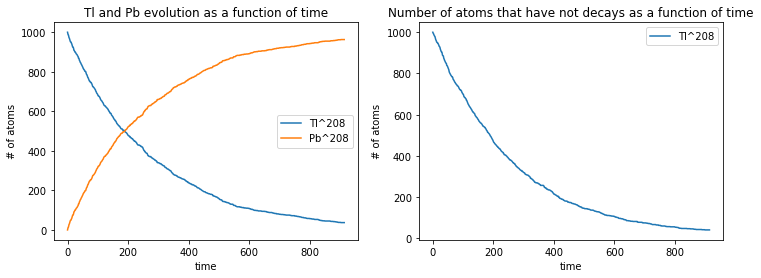

In [3]:
hl = 3.052*60 #-> tau
N0_Tl = 1000

def decay_prob(t):
    return 1-2**(-t/hl)

t0 = 0
t1 = 5*hl # process is over at approx 5 times tau
times = range(t0, int(t1), 1)

Nt_Tl = []
Nt_Tl.append(N0_Tl)
x = np.random.rand(N0_Tl)

for t in times[1:]:
    Nt_Tl.append(N0_Tl-len(x[x<decay_prob(t)]))

plt.figure(figsize=(12,4))

plt.subplot(121)

plt.title("Tl and Pb evolution as a function of time")
plt.xlabel("time")
plt.ylabel("# of atoms")
plt.plot(times, Nt_Tl, label="Tl^208")
plt.plot(times, N0_Tl-np.array(Nt_Tl), label="Pb^208")
plt.legend()


def expon_pdf(x, mu=np.log(2)/hl):
    """PDF of exponential distribution."""
    return mu*np.exp(-mu*x)

def expon_icdf(z, mu=np.log(2)/hl):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-z)/mu

u = np.random.uniform(0, 1, N0_Tl)
v = expon_icdf(u)

Nt_Tl = []
Nt_Tl.append(N0_Tl)

for t in times[1:]:
    Nt_Tl.append(N0_Tl-len(v[v<t]))

plt.subplot(122)
plt.title("Number of atoms that have not decays as a function of time")
plt.xlabel("time")
plt.ylabel("# of atoms")
plt.plot(times, Nt_Tl, label="Tl^208")
plt.legend()
plt.show()
#plt.plot(times, expon_pdf(times), linewidth=2)


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
from scipy import constants

In [5]:
e  = constants.elementary_charge
e0 = constants.epsilon_0
a0 = 4*np.pi*e0*constants.hbar**2/(constants.m_e*e**2)

def theta(b, Z, E):
    return 2*np.arctan(Z*e**2/(2*np.pi*e0*E*b))

The fraction of backscattered particles is 0.1632 %


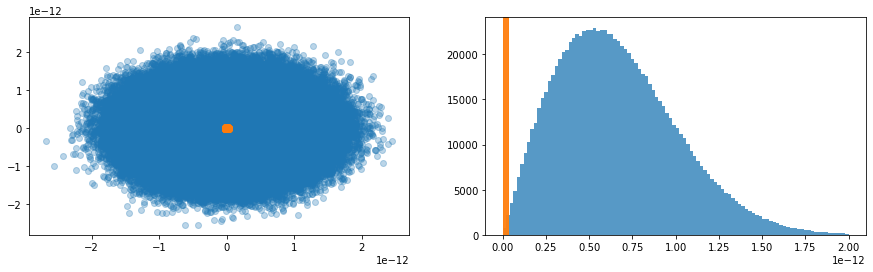

In [6]:
E = 7.7e6*e
Z = 79
N = 1e6

# beam definition
mu   = [0,0]
cov  = np.eye(2)*(a0*0.01)**2
beam = np.random.multivariate_normal(mu, cov, int(N)).T

# compute backscattered particles
b = np.sqrt(np.sum(beam**2, axis=0))
scatt_angle = theta(b, Z, E)
back_scatt  = scatt_angle[scatt_angle>np.pi/2]
print("The fraction of backscattered particles is %5.4f %%"%(len(back_scatt)*100/N))

# significative plots to detect the backscatter condition on the impact parameter
b_beam = [beam[0][scatt_angle>np.pi/2], beam[1][scatt_angle>np.pi/2]]

plt.figure(figsize=(15,4))

plt.subplot(121)
plt.scatter(beam[0], beam[1], alpha=0.3)
plt.scatter(b_beam[0], b_beam[1], alpha=0.3, label='backscattered')

plt.subplot(122)
plt.hist(b, bins=100, range=[0, 2e-12], alpha=0.75)
plt.axvspan(b[scatt_angle>np.pi/2].min(), b[scatt_angle>np.pi/2].max(), color='tab:orange', alpha=0.95)
plt.show()


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [7]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

# hit/miss method
N=int(1e6)
count=0
for i in range(N):
    x=np.random.uniform(0, 2)
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N

p = count/N
err_I = 2*np.sqrt(N*p*(1-p))/N # variance of count, following binomial distribution, is np(1-p)
print("hit/miss method = %6.5f +- %6.5f"%(I, err_I))

# mean value method
x = np.linspace(0.001, 1.999, N)
I = 2*np.sum(f(x))/N
err_I = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)
print("mean value method = %6.5f +- %6.5f"%(I, err_I))

hit/miss method = 1.45139 +- 0.00089
mean value method = 1.45185 +- 0.00053


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [8]:
def f(x):                  
    sq_sum = np.sum(x**2, axis=0)      
    return np.array([1 if (s<=1) else 0 for s in sq_sum]) 

# 2D
N = int(1e6)
x = np.random.uniform(-1, 1, (2, N))
I = 2**2*np.sum(f(x))/N
err_I = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)
print("I_2D = %6.5f +- %6.5f"%(I, err_I))

# 10D
x = np.random.uniform(-1, 1, (10, N))
I = 2**10*np.sum(f(x))/N
err_I = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)
print("I_10D = %6.5f +- %6.5f"%(I, err_I))


I_2D = 3.14209 +- 0.00082
I_10D = 2.54771 +- 0.00010


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [9]:
def w(x):
    return 1/(np.sqrt(x))

def f(x):
    return x**-0.5/(np.exp(x)+1)

x = np.random.rand(N)**2
I = 2/N*np.sum(f(x)/w(x))
print("I = %6.5f"%(I))

I = 0.83904
